In [47]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates
%matplotlib inline

## Overview

**Data**: Data on users starting a free trial with the service for a few regions of the
San Francisco East Bay Area in April and May of this year.
<br>Those users who subscribed to the service have a date value in the subscription_date column of the table.
The created_date indicates the date a user signed up for a free trial of the service.
<br>**Key event**: New feature launched May 1st (05/01/20): ‘automated concierge’ charging, in which
company employees detect whether users’ bikes are low on charge and automatically charge
them up as needed, without requiring a charge request from the user.

**Primary Question**: She wants to know whether the release of this new feature seems to have had an **impact on the
percentage of users subscribing to the platform after a 7-day free trial.** 

**Secondary Questions:**
1. Was there a meaningful change in the percentage of users subscribing to the platform
overall after the service was introduced, relative to those starting a trial before May 1st?
2. Can we see whether the new service may have been associated with changes in
subscription rates for users in some areas, with specific bike models or other elements in
the data?
3. Can you give a 3 - 4 sentence summary of your key observations from the data to help
prepare her for an investor conversation? Was the ‘automated concierge’ feature
beneficial to increasing user growth? Should she maintain the service going forward?

**Initial thoughts**
1. Calculate daily, weekly subscription rate over time of release of feature. Graph to visualize
2. Subscription rate based on segments. Be wary of absolute segment size, and call out when minimal/not stat sig (as well as p-hacking)
3. Cost/benefit of concierge. Recommend avenues for further exploration

## Data Processing

In [5]:
df = pd.read_csv('exercise_conversion_data.csv')

In [6]:
df.shape

(447, 5)

In [7]:
df.head()

,user_id,bike_model_id,city,created_date,subscription_date
0,110,1.0,Emeryville,5/1/20,NaN
1,111,4.0,Alameda,5/13/20,NaN
2,112,5.0,Berkeley,5/1/20,NaN
3,113,NaN,Oakland,5/2/20,NaN
4,114,5.0,Emeryville,5/4/20,NaN


In [8]:
df.describe(include='all')

,user_id,bike_model_id,city,created_date,subscription_date
count,447.000000,406.000000,431,431,112
unique,NaN,NaN,5,31,30
top,NaN,NaN,Oakland,5/2/20,5/18/20
freq,NaN,NaN,193,30,8
mean,336.483221,5.036946,NaN,NaN,NaN
std,129.936908,2.468791,NaN,NaN,NaN
min,110.000000,1.000000,NaN,NaN,NaN
25%,225.500000,4.000000,NaN,NaN,NaN
50%,337.000000,5.000000,NaN,NaN,NaN
75%,448.500000,7.000000,NaN,NaN,NaN


In [9]:
df.dtypes

user_id                int64
bike_model_id        float64
city                  object
created_date          object
subscription_date     object
dtype: object

#### Create a boolean field for subscribed, for ease of calculating subscription rate

In [10]:
df['subscribed'] = ~df.subscription_date.isna()

In [11]:
print("Subscription rate all time")
df.subscribed.value_counts(normalize=True, ascending=True)

Subscription rate all time


True     0.250559
False    0.749441
Name: subscribed, dtype: float64

**Convert date fields to pandas datetime**

In [12]:
df.created_date = pd.to_datetime(df.created_date)
df.subscription_date = pd.to_datetime(df.subscription_date)

In [13]:
df.set_index('created_date', inplace=True)

In [14]:
df.head()

,user_id,bike_model_id,city,subscription_date,subscribed
created_date,,,,,
2020-05-01,110,1.0,Emeryville,NaT,False
2020-05-13,111,4.0,Alameda,NaT,False
2020-05-01,112,5.0,Berkeley,NaT,False
2020-05-02,113,NaN,Oakland,NaT,False
2020-05-04,114,5.0,Emeryville,NaT,False


#### Pull in date formats of month of concierge for vertical line graphing

In [15]:
day_of_launch = '2020-05-01'

In [16]:
print("Month of launch: %s" % df[df.index==day_of_launch].index.month[0])
print("Week of launch: %s" % df[df.index==day_of_launch].index.week[0])
print("Day of launch: %s" % df[df.index==day_of_launch].index.dayofyear[0])

Month of launch: 5
Week of launch: 18
Day of launch: 122


In [45]:
print("Free Trials per Month:\n",df.index.month_name().value_counts(),"\n")

print(df.groupby(df.index.month_name())['subscribed'].value_counts())

Free Trials per Month:
 May      292
April    139
Name: created_date, dtype: int64 

created_date  subscribed
April         False         104
              True           35
May           False         215
              True           77
Name: subscribed, dtype: int64


In [17]:
grouped = df.groupby(df.index.month_name())['subscribed'].mean()
print(grouped)

created_date
April    0.251799
May      0.263699
Name: subscribed, dtype: float64


#### Significance Calculation in Periods Before and After Concierge Launch

In [50]:
count = np.array([35, 77])
nobs = np.array([139, 292])
stat, pval = proportions_ztest(count, nobs)
print('P-Value:','{0:0.3f}'.format(pval))

P-Value: 0.792


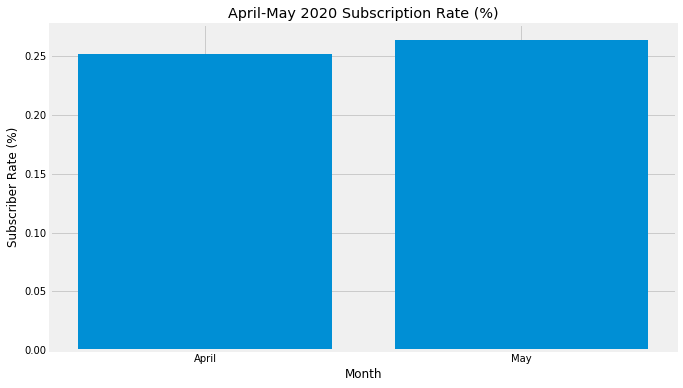

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('Month')
ax.set_ylabel('Subscriber Rate (%)')
ax.set_title('April-May 2020 Subscription Rate (%)')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

In [19]:
grouped = df.groupby(df.index.weekofyear)['subscribed'].mean()

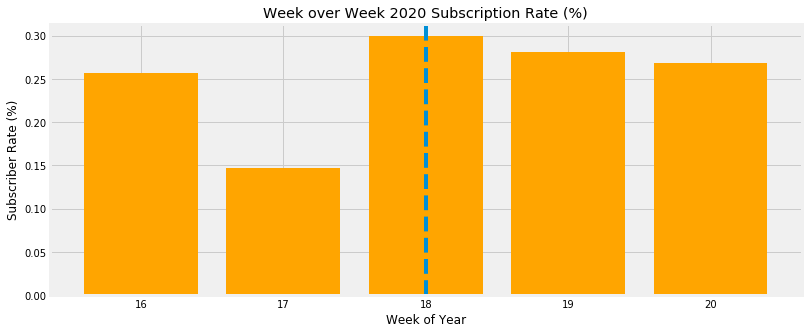

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(grouped.index, grouped.values, color='orange')
ax.axvline(18, linestyle="--")
ax.set_xlabel('Week of Year')
ax.set_ylabel('Subscriber Rate (%)')
ax.set_title('Week over Week 2020 Subscription Rate (%)')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

In [21]:
grouped = df.groupby(df.index.dayofyear)['subscribed'].mean()

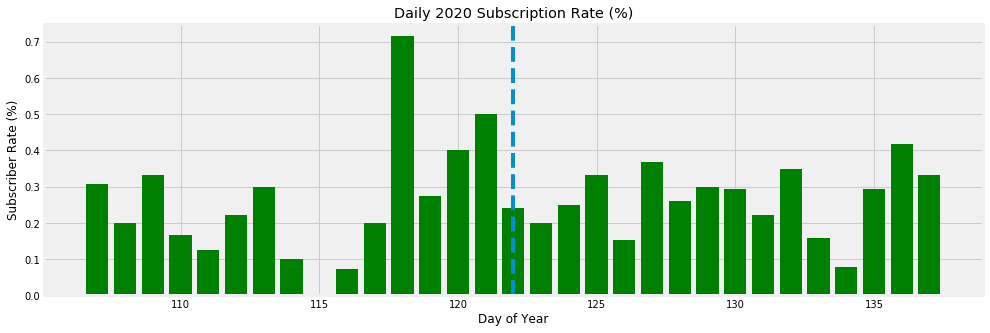

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(grouped.index, grouped.values, color='green')
ax.axvline(122, linestyle="--")
ax.set_ylabel('Subscriber Rate (%)')
ax.set_xlabel('Day of Year')
ax.set_title('Daily 2020 Subscription Rate (%)')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

## Investigate Subscriber Rate in Cities

In [86]:
grouped = df.groupby([df.index.month_name(),'city'])['subscribed'].mean().unstack()
grouped

city,Alameda,Berkeley,Emeryville,Oakland,San Leandro
created_date,,,,,
April,0.176471,0.281250,0.384615,0.257143,0.000000
May,0.305556,0.285714,0.366667,0.203252,0.307692


In [88]:
grouped_counts = df.groupby([df.index.month_name(),'city'])['subscribed'].value_counts().unstack()
grouped_counts

subscribed                False  True 
created_date city                     
April        Alameda       14.0    3.0
             Berkeley      23.0    9.0
             Emeryville     8.0    5.0
             Oakland       52.0   18.0
             San Leandro    7.0    NaN
May          Alameda       25.0   11.0
             Berkeley      55.0   22.0
             Emeryville    19.0   11.0
             Oakland       98.0   25.0
             San Leandro   18.0    8.0

Will our count of subscribers is growing, the subscription rate is not significantly, and Oakland actually went down.

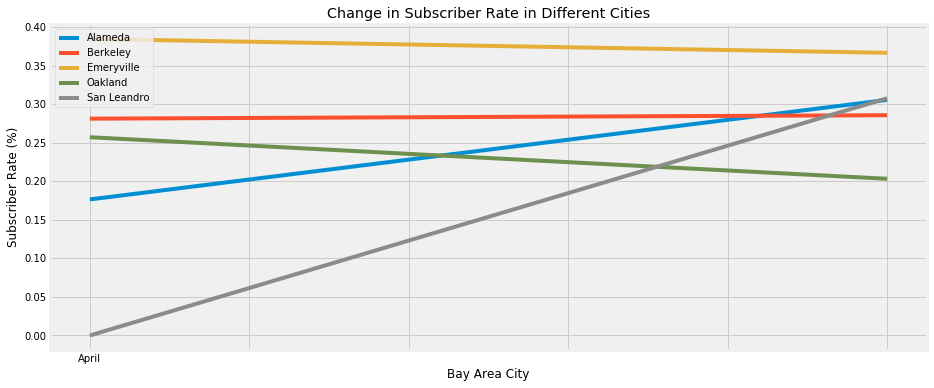

In [98]:
fig, ax = plt.subplots(figsize=(14,6))

grouped.plot(kind='line', ax=ax)
plt.title('Change in Subscriber Rate in Different Cities')
plt.xlabel('Bay Area City')
plt.ylabel('Subscriber Rate (%)')
plt.legend(loc='upper left')
plt.show()

## Investigate Subscriber Rate by Bike Model

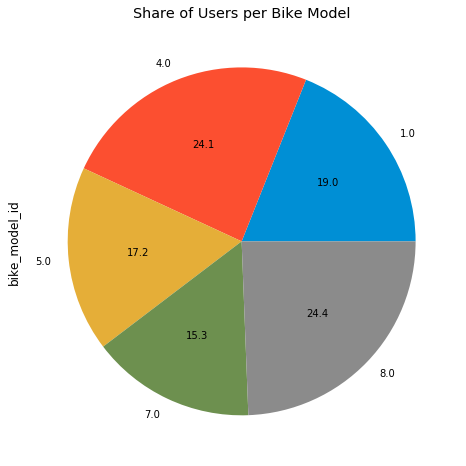

In [146]:
df.groupby('bike_model_id')['bike_model_id'].count().plot(kind='pie', autopct='%.1f', figsize=(8,8))
plt.title('Share of Users per Bike Model')
plt.show()

In [100]:
grouped = df.groupby([df.index.month_name(),'bike_model_id'])['subscribed'].mean().unstack()
grouped

bike_model_id,1.0,4.0,5.0,7.0,8.0
created_date,,,,,
April,0.20,0.000000,0.000000,0.346154,0.301887
May,0.45,0.204545,0.075758,0.625000,0.311111


In [103]:
grouped_counts = df.groupby([df.index.month_name(),'bike_model_id'])['subscribed'].value_counts().unstack()
grouped_counts

subscribed                  False  True 
created_date bike_model_id              
April        1.0             28.0    7.0
             4.0              5.0    NaN
             5.0              2.0    NaN
             7.0             17.0    9.0
             8.0             37.0   16.0
May          1.0             22.0   18.0
             4.0             70.0   18.0
             5.0             61.0    5.0
             7.0             12.0   20.0
             8.0             31.0   14.0

Only changes worth exploring are Models 1 and 7.

In [104]:
# Investigating Model 1
count = np.array([7, 18])
nobs = np.array([35, 40])
stat, pval = proportions_ztest(count, nobs)
print('P-Value:','{0:0.3f}'.format(pval))

P-Value: 0.022


In [105]:
# Investigating Model 7
count = np.array([9, 20])
nobs = np.array([26, 32])
stat, pval = proportions_ztest(count, nobs)
print('P-Value:','{0:0.3f}'.format(pval))

P-Value: 0.035


Both results are significant, which is exciting. Worth diving in more..

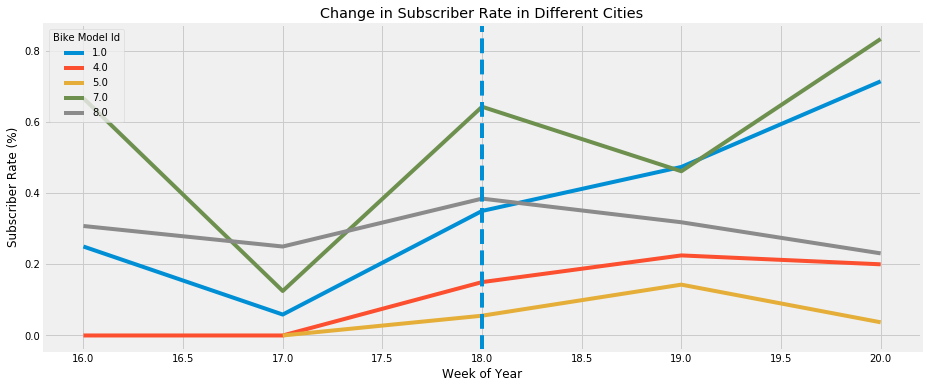

In [126]:
grouped = df.groupby([df.index.week,'bike_model_id'])['subscribed'].mean().unstack()
grouped


fig, ax = plt.subplots(figsize=(14,6))

grouped.plot(kind='line', ax=ax)
ax.axvline(18, linestyle="--")
plt.title('Change in Subscriber Rate in Different Cities')
plt.xlabel('Week of Year')
plt.ylabel('Subscriber Rate (%)')
plt.legend(loc='upper left', title='Bike Model Id')
plt.show()

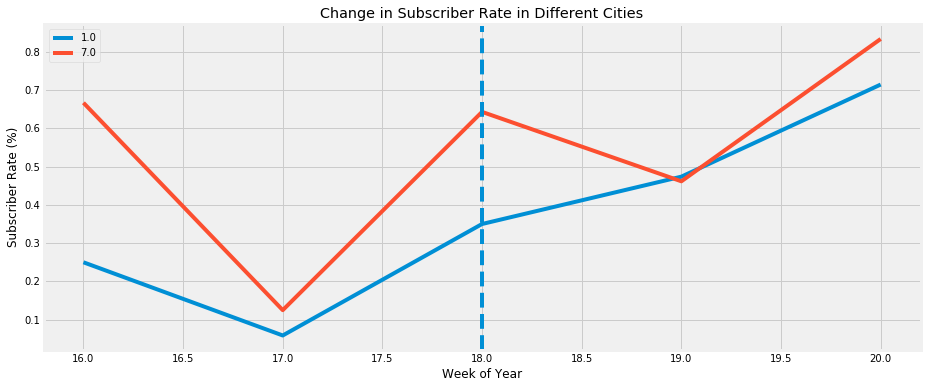

In [125]:
stat_sig_models = df[df.bike_model_id.isin([1.0,7.0])]
grouped = stat_sig_models.groupby([stat_sig_models.index.week,'bike_model_id'])['subscribed'].mean().unstack()

fig, ax = plt.subplots(figsize=(14,6))

grouped.plot(kind='line', ax=ax)
ax.axvline(18, linestyle="--")
plt.title('Change in Subscriber Rate in Different Cities')
plt.xlabel('Week of Year')
plt.ylabel('Subscriber Rate (%)')
plt.legend(loc='upper left')
plt.show()